# Install Dependencies

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%%capture
!pip install nibabel

In [4]:
import numpy as np
import nibabel as nib
import glob
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from tifffile import imsave

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

# Testing Training Data

In [5]:
TRAIN_DATASET_PATH = '/content/drive/MyDrive/Machine-Learning-Biomedicine/Deep_Brain_Seg/BraTS2020/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/'

In [6]:
test_image_flair=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_355/BraTS20_Training_355_flair.nii').get_fdata()
print(test_image_flair.max())
#Scalers are applied to 1D so let us reshape and then reshape back to original shape.
test_image_flair=scaler.fit_transform(test_image_flair.reshape(-1, test_image_flair.shape[-1])).reshape(test_image_flair.shape)

1854.603271484375


In [6]:
test_image_t1=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_355/BraTS20_Training_355_t1.nii').get_fdata()
test_image_t1=scaler.fit_transform(test_image_t1.reshape(-1, test_image_t1.shape[-1])).reshape(test_image_t1.shape) #flatten the dimension of the array of the images by 1 dimension

test_image_t1ce=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_355/BraTS20_Training_355_t1ce.nii').get_fdata()
test_image_t1ce=scaler.fit_transform(test_image_t1ce.reshape(-1, test_image_t1ce.shape[-1])).reshape(test_image_t1ce.shape)

test_image_t2=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_355/BraTS20_Training_355_t2.nii').get_fdata()
test_image_t2=scaler.fit_transform(test_image_t2.reshape(-1, test_image_t2.shape[-1])).reshape(test_image_t2.shape)

test_mask=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_355/BraTS20_Training_355_seg.nii').get_fdata()
test_mask=test_mask.astype(np.uint8)

print(np.unique(test_mask))  #0, 1, 2, 4 (Need to reencode to 0, 1, 2, 3)
test_mask[test_mask==4] = 3  #Reassign mask values 4 to 3
print(np.unique(test_mask))

[0 1 2 4]
[0 1 2 3]


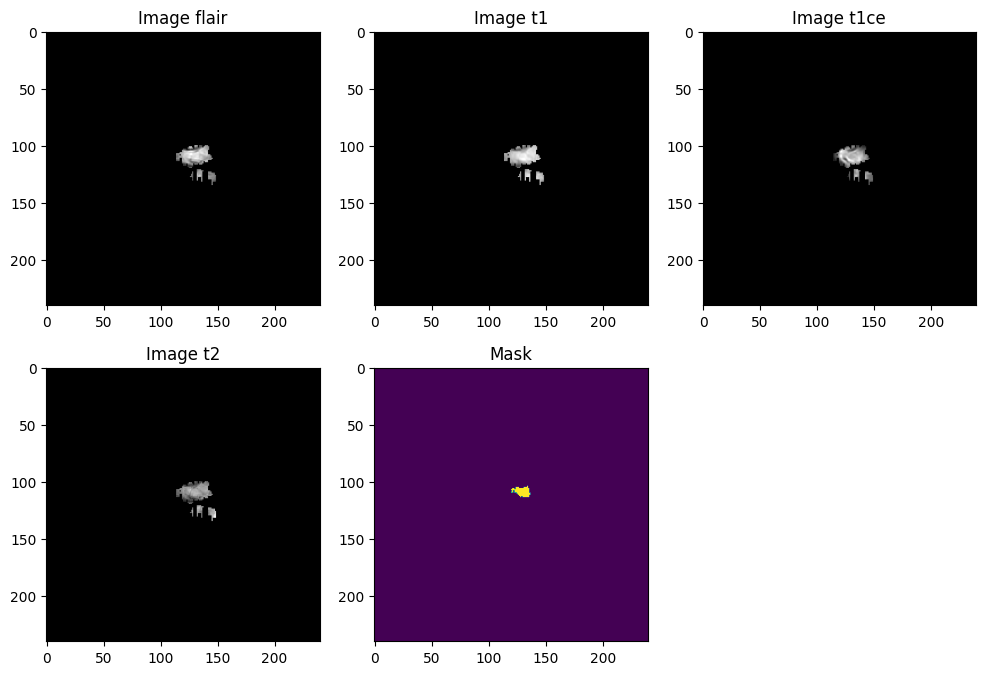

In [7]:
import random
n_slice=random.randint(0, test_mask.shape[2])

plt.figure(figsize=(12, 8))

plt.subplot(231)
plt.imshow(test_image_flair[:,:,n_slice], cmap='gray')
plt.title('Image flair')
plt.subplot(232)
plt.imshow(test_image_t1[:,:,n_slice], cmap='gray')
plt.title('Image t1')
plt.subplot(233)
plt.imshow(test_image_t1ce[:,:,n_slice], cmap='gray')
plt.title('Image t1ce')
plt.subplot(234)
plt.imshow(test_image_t2[:,:,n_slice], cmap='gray')
plt.title('Image t2')
plt.subplot(235)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

Note that Flair, T1ce, and T2 contain the most information (What do they contain?) Thus combine these 3 images into a single multichannel image

In [8]:
combined_stack = np.stack([test_image_flair, test_image_t1ce, test_image_t2], axis=3)
print(combined_stack.shape)
#Currently, it is 240, 240, 155. Idealy, it should be 128x128x128

(240, 240, 155, 3)


In [9]:
combined_stack=combined_stack[56:184, 56:184, 13:141] #resize to 128x128x128
print(combined_stack.shape)

test_mask = test_mask[56:184, 56:184, 13:141] #apply same transformations to test mask
print(test_mask.shape)

(128, 128, 128, 3)
(128, 128, 128)


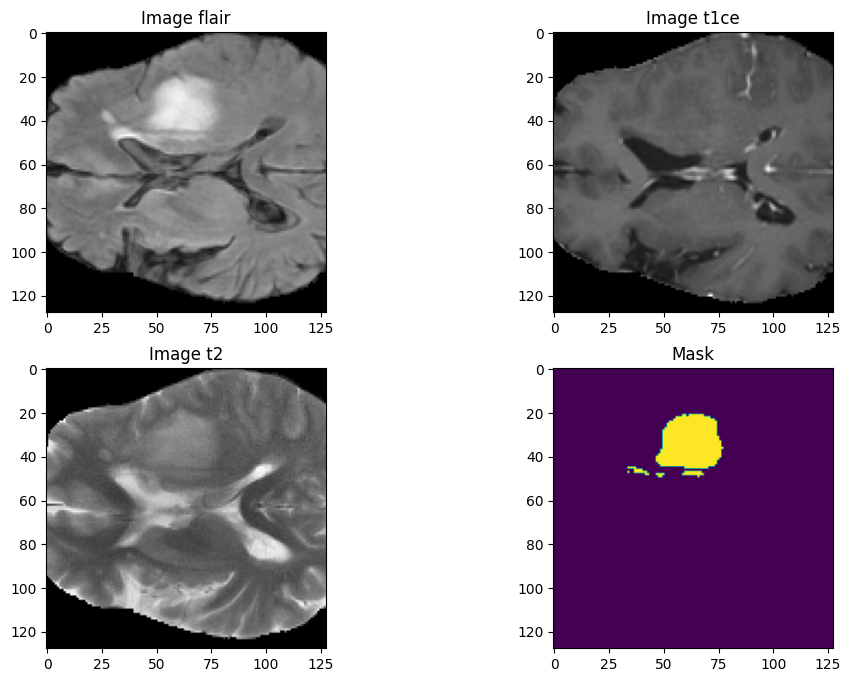

In [15]:
n_slice=random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(combined_stack[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(combined_stack[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(combined_stack[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

In [11]:
np.save('/content/drive/MyDrive/Machine-Learning-Biomedicine/Deep_Brain_Seg/BraTS2020/BraTS2020_TrainingData/combined355.npy', combined_stack)
#Verify image is being read properly

In [12]:
my_img=np.load('/content/drive/MyDrive/Machine-Learning-Biomedicine/Deep_Brain_Seg/BraTS2020/BraTS2020_TrainingData/combined355.npy')
print(my_img.shape)

(128, 128, 128, 3)


In [16]:
test_mask = to_categorical(test_mask, num_classes=4)
print(test_mask.shape)

(128, 128, 128, 4)


In [17]:
t2_list = sorted(glob.glob(TRAIN_DATASET_PATH + '*/*t2.nii'))
t1ce_list = sorted(glob.glob(TRAIN_DATASET_PATH + '*/*t1ce.nii'))
flair_list = sorted(glob.glob(TRAIN_DATASET_PATH + '*/*flair.nii'))
mask_list = sorted(glob.glob(TRAIN_DATASET_PATH + '*/*seg.nii'))

In [25]:
print('t2_list: ' + str(len(t2_list)))
print('t1ce_list: ' + str(len(t1ce_list)))
print('flair_list: ' + str(len(flair_list)))
print('mask_list: ' + str(len(mask_list)))

t2_list: 369
t1ce_list: 369
flair_list: 369
mask_list: 369


In [27]:
for img in range(len(t2_list)):   #Using t2_list as all lists are of same size
    print("Now preparing image and masks number: ", img)

    temp_image_t2=nib.load(t2_list[img]).get_fdata()
    temp_image_t2=scaler.fit_transform(temp_image_t2.reshape(-1, temp_image_t2.shape[-1])).reshape(temp_image_t2.shape)

    temp_image_t1ce=nib.load(t1ce_list[img]).get_fdata()
    temp_image_t1ce=scaler.fit_transform(temp_image_t1ce.reshape(-1, temp_image_t1ce.shape[-1])).reshape(temp_image_t1ce.shape)

    temp_image_flair=nib.load(flair_list[img]).get_fdata()
    temp_image_flair=scaler.fit_transform(temp_image_flair.reshape(-1, temp_image_flair.shape[-1])).reshape(temp_image_flair.shape)

    temp_mask=nib.load(mask_list[img]).get_fdata()
    temp_mask=temp_mask.astype(np.uint8)
    temp_mask[temp_mask==4] = 3  #Reassign mask values 4 to 3
    #print(np.unique(temp_mask))

    temp_combined_images = np.stack([temp_image_flair, temp_image_t1ce, temp_image_t2], axis=3)

    #Crop to a size to be divisible by 64 so we can later extract 64x64x64 patches.
    #cropping x, y, and z
    temp_combined_images=temp_combined_images[56:184, 56:184, 13:141]
    temp_mask = temp_mask[56:184, 56:184, 13:141]

    val, counts = np.unique(temp_mask, return_counts=True)

    if (1 - (counts[0]/counts.sum())) > 0.01:  #At least 1% useful volume with labels that are not 0
        print("Save Me")
        temp_mask= to_categorical(temp_mask, num_classes=4)
        np.save('/content/drive/MyDrive/Machine-Learning-Biomedicine/Deep_Brain_Seg/BraTS2020/BraTS2020_TrainingData/input_data_3channels/images/image_'+str(img)+'.npy', temp_combined_images)
        np.save('/content/drive/MyDrive/Machine-Learning-Biomedicine/Deep_Brain_Seg/BraTS2020/BraTS2020_TrainingData/input_data_3channels/masks/mask_'+str(img)+'.npy', temp_mask)

    else:
        print("I am useless")

Now preparing image and masks number:  0
Save Me
Now preparing image and masks number:  1
Save Me
Now preparing image and masks number:  2
Save Me
Now preparing image and masks number:  3
Save Me
Now preparing image and masks number:  4
I am useless
Now preparing image and masks number:  5
Save Me
Now preparing image and masks number:  6
Save Me
Now preparing image and masks number:  7
Save Me
Now preparing image and masks number:  8
Save Me
Now preparing image and masks number:  9
Save Me
Now preparing image and masks number:  10
Save Me
Now preparing image and masks number:  11
Save Me
Now preparing image and masks number:  12
Save Me
Now preparing image and masks number:  13
Save Me
Now preparing image and masks number:  14
Save Me
Now preparing image and masks number:  15
Save Me
Now preparing image and masks number:  16
Save Me
Now preparing image and masks number:  17
Save Me
Now preparing image and masks number:  18
Save Me
Now preparing image and masks number:  19
Save Me
Now p

In [9]:
images_len = glob.glob("/content/drive/MyDrive/Machine-Learning-Biomedicine/Deep_Brain_Seg/BraTS2020/BraTS2020_TrainingData/input_data_3channels/images/*")
masks_len = glob.glob("/content/drive/MyDrive/Machine-Learning-Biomedicine/Deep_Brain_Seg/BraTS2020/BraTS2020_TrainingData/input_data_3channels/masks/*")
print(str(len(images_len)))
print(str(len(masks_len)))

344
344


# Split into Testing and Validation (Using Training Data)

In [ ]:
%%capture
!pip install split-folders

In [52]:
import splitfolders
import shutil

input_folder = '/content/drive/MyDrive/Machine-Learning-Biomedicine/Deep_Brain_Seg/BraTS2020/BraTS2020_TrainingData/input_data_3channels/'
output_folder = '/content/drive/MyDrive/Machine-Learning-Biomedicine/Deep_Brain_Seg/BraTS2020/BraTS2020_TrainingData/input_data_128/'

splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(.80, .20), group_prefix=None)

Copying files: 688 files [12:50,  1.12s/ files]


# Testing Data (Useless ATM)

In [23]:
VALIDATION_DATASET_PATH = '/content/drive/MyDrive/Machine-Learning-Biomedicine/Deep_Brain_Seg/BraTS2020/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData/'

In [28]:
val_test_image_flair=nib.load(VALIDATION_DATASET_PATH + 'BraTS20_Validation_125/BraTS20_Validation_125_flair.nii').get_fdata()
print(test_image_flair.max())
#Scalers are applied to 1D so let us reshape and then reshape back to original shape.
test_image_flair=scaler.fit_transform(test_image_flair.reshape(-1, test_image_flair.shape[-1])).reshape(test_image_flair.shape)

1.0


In [29]:
val_test_image_t1=nib.load(VALIDATION_DATASET_PATH + 'BraTS20_Validation_125/BraTS20_Validation_125_t1.nii').get_fdata()
val_test_image_t1=scaler.fit_transform(test_image_t1.reshape(-1, test_image_t1.shape[-1])).reshape(test_image_t1.shape) #flatten the dimension of the array of the images by 1 dimension

val_test_image_t1ce=nib.load(VALIDATION_DATASET_PATH + 'BraTS20_Validation_125/BraTS20_Validation_125_t1ce.nii').get_fdata()
val_test_image_t1ce=scaler.fit_transform(test_image_t1ce.reshape(-1, test_image_t1ce.shape[-1])).reshape(test_image_t1ce.shape)

val_test_image_t2=nib.load(VALIDATION_DATASET_PATH + 'BraTS20_Validation_125/BraTS20_Validation_125_t2.nii').get_fdata()
val_test_image_t2=scaler.fit_transform(test_image_t2.reshape(-1, test_image_t2.shape[-1])).reshape(test_image_t2.shape)

print(val_test_image_t1.shape)

(240, 240, 155)


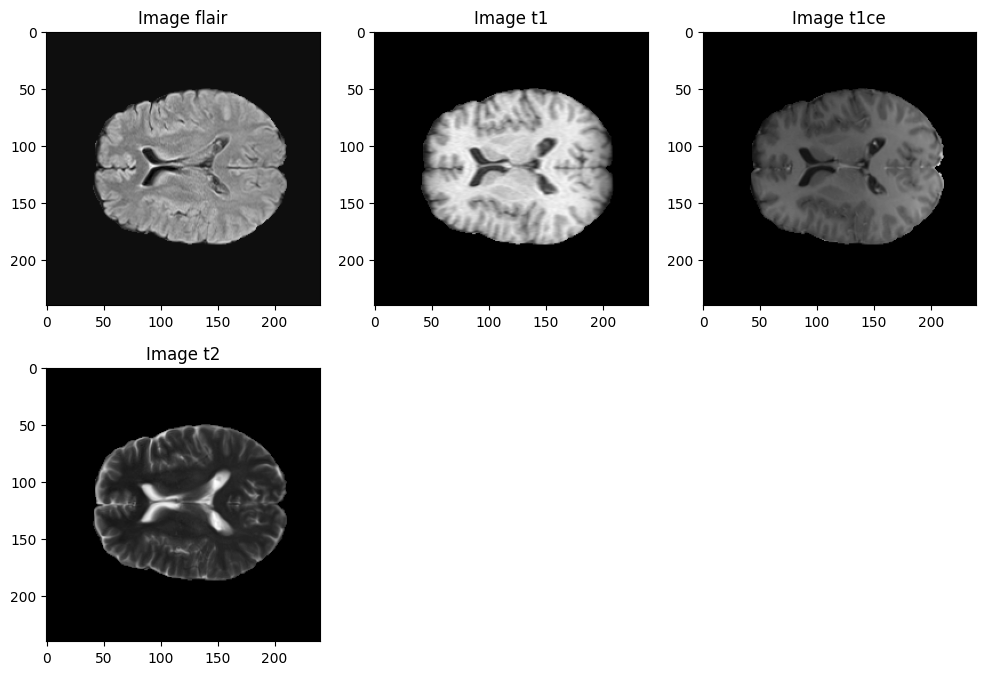

In [32]:
n_slice=random.randint(0, val_test_image_t1.shape[2])
plt.figure(figsize=(12, 8))

plt.subplot(231)
plt.imshow(val_test_image_flair[:,:,n_slice], cmap='gray')
plt.title('Image flair')
plt.subplot(232)
plt.imshow(val_test_image_t1[:,:,n_slice], cmap='gray')
plt.title('Image t1')
plt.subplot(233)
plt.imshow(val_test_image_t1ce[:,:,n_slice], cmap='gray')
plt.title('Image t1ce')
plt.subplot(234)
plt.imshow(val_test_image_t2[:,:,n_slice], cmap='gray')
plt.title('Image t2')
plt.show()

In [35]:
val_combined_stack = np.stack([val_test_image_flair, val_test_image_t1ce, val_test_image_t2], axis=3)
print(combined_stack.shape)

(240, 240, 155, 3)


In [36]:
val_combined_stack=val_combined_stack[56:184, 56:184, 13:141] #resize to 128x128x128
print(val_combined_stack.shape)

(128, 128, 128, 3)


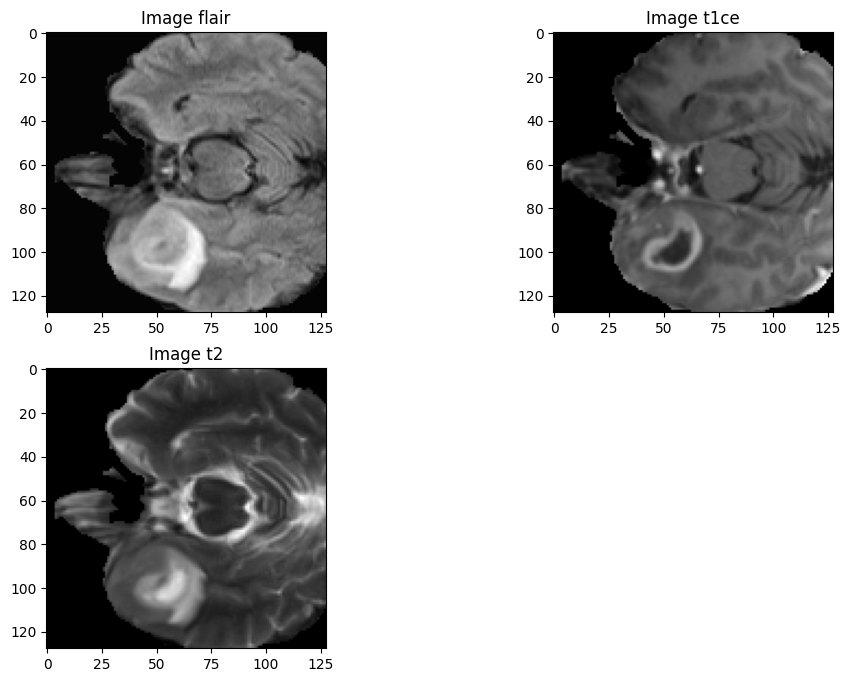

In [47]:
n_slice=random.randint(0, val_test_image_t1.shape[2])
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(val_combined_stack[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(val_combined_stack[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(val_combined_stack[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.show()

In [49]:
np.save('/content/drive/MyDrive/Machine-Learning-Biomedicine/Deep_Brain_Seg/BraTS2020/BraTS2020_ValidationData/combined125.npy', val_combined_stack)
#Verify image is being read properly

In [50]:
val_my_img=np.load('/content/drive/MyDrive/Machine-Learning-Biomedicine/Deep_Brain_Seg/BraTS2020/BraTS2020_ValidationData/combined125.npy')
print(val_my_img.shape)

(128, 128, 128, 3)


In [51]:
val_t2_list = sorted(glob.glob(VALIDATION_DATASET_PATH + '*/*t2.nii'))
val_t1ce_list = sorted(glob.glob(VALIDATION_DATASET_PATH + '*/*t1ce.nii'))
val_flair_list = sorted(glob.glob(VALIDATION_DATASET_PATH + '*/*flair.nii'))

print('val_t2_list: ' + str(len(val_t2_list)))
print('val_t1ce_list: ' + str(len(val_t1ce_list)))
print('val_flair_list: ' + str(len(val_flair_list)))

val_t2_list: 125
val_t1ce_list: 125
val_flair_list: 125


In [ ]:
for img in range(len(t2_list)):   #Using t2_list as all lists are of same size
    print("Now preparing image and masks number: ", img)

    temp_image_t2=nib.load(t2_list[img]).get_fdata()
    temp_image_t2=scaler.fit_transform(temp_image_t2.reshape(-1, temp_image_t2.shape[-1])).reshape(temp_image_t2.shape)

    temp_image_t1ce=nib.load(t1ce_list[img]).get_fdata()
    temp_image_t1ce=scaler.fit_transform(temp_image_t1ce.reshape(-1, temp_image_t1ce.shape[-1])).reshape(temp_image_t1ce.shape)

    temp_image_flair=nib.load(flair_list[img]).get_fdata()
    temp_image_flair=scaler.fit_transform(temp_image_flair.reshape(-1, temp_image_flair.shape[-1])).reshape(temp_image_flair.shape)

    temp_combined_images = np.stack([temp_image_flair, temp_image_t1ce, temp_image_t2], axis=3)

    #Crop to a size to be divisible by 64 so we can later extract 64x64x64 patches.
    #cropping x, y, and z
    temp_combined_images=temp_combined_images[56:184, 56:184, 13:141]

    val, counts = np.unique(temp_mask, return_counts=True)

    if (1 - (counts[0]/counts.sum())) > 0.01:  #At least 1% useful volume with labels that are not 0
        print("Save Me")
        temp_mask= to_categorical(temp_mask, num_classes=4)
        np.save('/content/drive/MyDrive/Machine-Learning-Biomedicine/Deep_Brain_Seg/BraTS2020/BraTS2020_TrainingData/val_data_3channels/images/image_'+str(img)+'.npy', temp_combined_images)

    else:
        print("I am useless")